In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import numpy as np
import numpy.linalg as la

In [3]:
def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../shims/toric")   

import toric
import toric.samples
import toric.shims

#
# Helper functions for the toric libary
#

def vector3_to_str(v):
    return "(%.2f, %.2f, %.2f)" % (v.x(), v.y(), v.z())

def quaternion_to_str(q):
    return "(w,x,y,z): (%.2f, %.2f, %.2f, %.2f)" % (q.w(), q.x(), q.y(), q.z())

def slerp(p0, p1, t):
        omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
        so = np.sin(omega)
        return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

def drawSetup(fudgeX=2, fudgeY_pos=2,fudgeY_neg=8):
    pylab.rcParams['figure.figsize'] = 8, 8

    plt.axes().set_aspect('equal')
    fig = plt.gcf()
    
    # Set up plot size
    plt.axes().set_xlim((np.min([PA_1.x(), PB_1.x()])-fudgeX,np.max([PA_1.x(), PB_1.x()])+fudgeX))
    plt.axes().set_ylim((np.min([PA_1.y(), PB_1.y()])-fudgeY_neg,np.max([PA_1.y(), PB_1.y()])+fudgeY_pos))

    # Draw People Positions
    plt.scatter([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()],c="red",linewidths=0)
    line_AB = plt.Line2D([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()], c="black",alpha=0.3)
    fig.gca().add_artist(line_AB)

    # Draw Circles    
    circle_PA_1=plt.Circle((PA_1.x(),PA_1.y()),min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle((PB_1.x(),PB_1.y()),min_dist,color='g',alpha=0.5)
    
    fig.gca().add_artist(circle_PA_1)
    fig.gca().add_artist(circle_PB_1)

    plt.annotate(s="A", xy=(PA_1.x(),PA_1.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="B", xy=(PB_1.x(),PB_1.y()),xytext=(3,4),textcoords="offset points")
    
    # Draw Camera positions
    plt.scatter([C_1.x(), C_2.x()],[C_1.y(), C_2.y()],c="blue",linewidths=0)
    plt.annotate(s="C1", xy=(C_1.x(), C_1.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="C2", xy=(C_2.x(), C_2.y()),xytext=(3,4),textcoords="offset points")

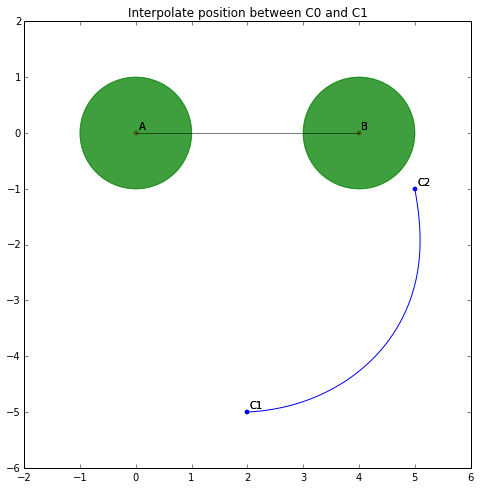

In [4]:
min_dist = 1                    # let's set a minimum distance of 1m
PA_1 = toric.Vector3(0,0,0)     # person A position
PB_1 = toric.Vector3(4,0,0)     # person B position
C_1 = toric.Vector3(2,-5,0)  # Starting camera position is *outside* of PA_1
C_2 = toric.Vector3( 5,-1,0)    # Ending camera position

drawSetup(fudgeY_neg=2)
plt.title("Interpolate position between C0 and C1")

C_1t = toric.Toric3_FromWorldPosition(C_1, PA_1, PB_1)
C_2t = toric.Toric3_FromWorldPosition(C_2, PA_1, PB_1)

interp = toric.ToricInterpolator(PA_1, PB_1, C_1t, C_2t)

t = np.linspace(0,1)

sigma = np.array([toric.Toric3_ToWorldPosition(interp.interpolate(a),PA_1,PB_1).np() for a in t])

drawSetup(fudgeY_neg=6)
plt.plot(sigma[:,0],sigma[:,1])

(0.92, 0.40, 0.00)
(-0.36, 0.82, -0.45)
(-0.18, 0.41, 0.89)
(-0.22, -0.05, 0.20)
(w,x,y,z): (0.95, -0.22, -0.05, 0.20)


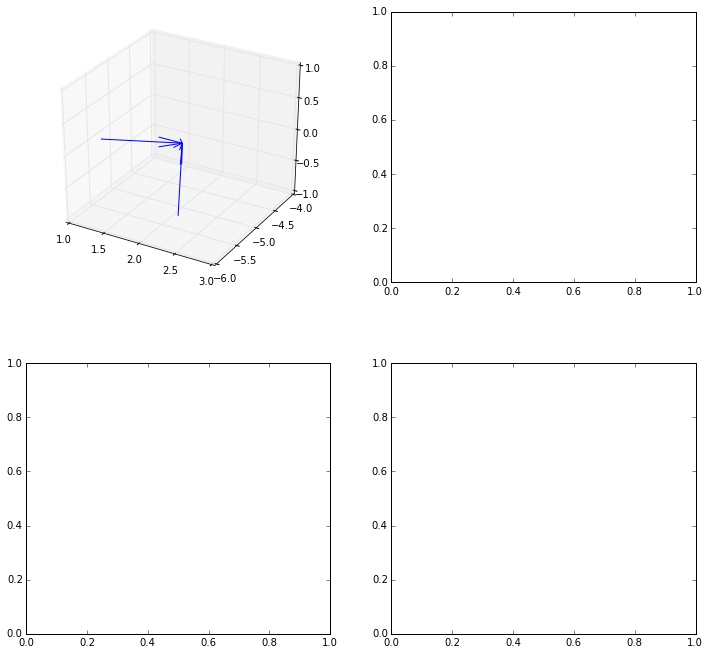

In [52]:
aspect = 16/9

SA_1 = toric.Vector2(0.33, 0.5);
SB_1 = toric.Vector2(0.66, 0.5);
fovX_1 = toric.RadianPi(2 * np.arctan(6/5)); # geometrically calculated by hand
fovY_1 = toric.RadianPi(fovX_1.valueRadians() / aspect);

SA_2 = toric.Vector2(0.33, 0.66);
SB_2 = toric.Vector2(0.8, 0.33);
fovX_2 = fovX_1
fovY_2 = fovY_1

v_0 = toric.Vector3(1,0,0)
rotation_0 = toric.Toric3_ComputeOrientationForTwoTargets(C_1, SA_1, SB_1, PA_1, PB_1, fovX_1, fovY_1)
rotation_1 = toric.Toric3_ComputeOrientationForTwoTargets(C_2, SA_1, SB_1, PA_1, PB_1, fovX_1, fovY_1)

matrix_0 = toric.Matrix3()
rotation_0.ToRotationMatrix(matrix_0)
print matrix_0.getColumn(0)
print matrix_0.getColumn(1)
print matrix_0.getColumn(2)

print rotation_0.v()
print quaternion_to_str(rotation_0)

#
# Graphing the rotation
#
pylab.rcParams['figure.figsize'] = 12, 16
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D

gs = gridspec.GridSpec(2, 2, width_ratios=[1,1], height_ratios=[1,1,1])

soa = np.array( [[C_1.x(), C_1.y(), C_1.z(), matrix_0.getColumn(0).x(), matrix_0.getColumn(0).y(), matrix_0.getColumn(0).z()], 
                 [C_1.x(), C_1.y(), C_1.z(), matrix_0.getColumn(1).x(), matrix_0.getColumn(1).y(), matrix_0.getColumn(1).z()],
                 [C_1.x(), C_1.y(), C_1.z(), matrix_0.getColumn(2).x(), matrix_0.getColumn(2).y(), matrix_0.getColumn(2).z()]]) 

X,Y,Z,U,V,W = zip(*soa)
fig = plt.figure()
f1 = fig.add_subplot(gs[0], projection='3d')
f2 = fig.add_subplot(gs[1])
f3 = fig.add_subplot(gs[2])
f4 = fig.add_subplot(gs[3])

f1.quiver(X,Y,Z,U,V,W)
f1.set_xlim([1,3])
f1.set_ylim([-6,-4])
f1.set_zlim([-1,1])


plt.show()